In [2]:
import json
from openai import OpenAI
import gurobipy as gp

client = OpenAI()

# -----------------------------
# 1. 基础数据：5 个回收点 + 8 个需求点
# -----------------------------

centers = ["R1", "R2", "R3", "R4", "R5"]
customers = ["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8"]

# 每个需求点每天的回收量需求
demand = {
    "D1": 40,
    "D2": 60,
    "D3": 50,
    "D4": 30,
    "D5": 70,
    "D6": 50,
    "D7": 40,
    "D8": 60,
}
total_demand = sum(demand.values())

# 每个回收中心的基础产能（没有故障时）
base_capacity = {
    "R1": 120,
    "R2": 100,
    "R3": 80,
    "R4": 90,
    "R5": 110,
}
total_capacity = sum(base_capacity.values())

print("总需求量:", total_demand)
print("总产能:", total_capacity)

# 构造一个简单的“运输成本矩阵”，让每个中心都能服务所有需求点
# 成本越小表示越便宜
center_index = {c: i for i, c in enumerate(centers)}
customer_index = {d: j for j, d in enumerate(customers)}

cost = {}
for c in centers:
    for d in customers:
        # 这里用一个简单的公式生成成本
        # 你可以以后替换为真实地理距离等
        i = center_index[c]
        j = customer_index[d]
        cost[(c, d)] = 2 + abs(i - (j % len(centers)))  # 取值大概在 2~6 之间

# -----------------------------
# 2. 封装一个求解函数：给定各中心产能 → 求最优调度
# -----------------------------

def solve_network(capacity, title="scenario"):
    """给定每个回收中心的产能，求最小运输成本，并返回结果字典。"""
    m = gp.Model(title)

    # 决策变量：x[c,d] = 从回收中心 c 运到需求点 d 的电池数量
    x = m.addVars(centers, customers, name="flow", lb=0)

    # 目标：总成本最小
    m.setObjective(
        gp.quicksum(cost[c, d] * x[c, d] for c in centers for d in customers),
        sense=gp.GRB.MINIMIZE,
    )

    # 需求约束：每个需求点必须被完全满足
    for d in customers:
        m.addConstr(gp.quicksum(x[c, d] for c in centers) == demand[d],
                    name=f"demand_{d}")

    # 产能约束：每个回收中心的总处理量不能超过它的产能
    for c in centers:
        m.addConstr(gp.quicksum(x[c, d] for d in customers) <= capacity[c],
                    name=f"capacity_{c}")

    # 关闭详细日志，让输出干净一点
    m.setParam("OutputFlag", 0)
    m.optimize()

    result = {
        "status": m.Status,
        "obj": None,
        "used_by_center": {},
        "utilization": {},
        "flows": {},
    }

    if m.Status == gp.GRB.OPTIMAL:
        result["obj"] = m.ObjVal
        for c in centers:
            used = sum(x[c, d].X for d in customers)
            result["used_by_center"][c] = used
            result["utilization"][c] = used / capacity[c] if capacity[c] > 0 else 0.0

        # 记录每条弧的流量（只保留 > 0 的）
        for c in centers:
            for d in customers:
                val = x[c, d].X
                if val > 1e-6:
                    result["flows"][(c, d)] = val

    return result

# -----------------------------
# 3. 先跑一个“基准场景”：无故障
# -----------------------------

baseline_result = solve_network(base_capacity, title="baseline")

print("\n===== 基准场景（无故障） =====")
print("最小总成本:", baseline_result["obj"])
print("\n各回收中心产能利用情况：")
for c in centers:
    used = baseline_result["used_by_center"][c]
    cap = base_capacity[c]
    util = baseline_result["utilization"][c]
    print(f"  {c}: 使用 {used:.1f} / 产能 {cap}  (利用率 {util:.1%})")

# -----------------------------
# 4. 用 LLM 解析一个“故障场景”
# -----------------------------

scenario_natural = "未来 5 天，回收中心 R3 由于设备故障，产能下降到 40%。"

system_prompt = """
你是锂电池回收供应链专家，专门把中文故障描述解析成结构化参数。

请严格输出一个 JSON 对象（不要有多余文字），格式为：
{
  "center_id": "R1",
  "capacity_factor": 0.5,
  "duration_days": 3,
  "summary_zh": "一句中文摘要"
}

字段含义：
- center_id: 受到影响的回收中心编号（R1/R2/R3/R4/R5 之一）
- capacity_factor: 故障期间的产能倍率（例如 0.4 表示剩 40% 产能）
- duration_days: 故障持续天数（整数）
- summary_zh: 用一句话总结这个场景
"""

resp = client.responses.create(
    model="gpt-5-mini",   # 如有问题可以改为 "gpt-4.1-mini"
    input=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": scenario_natural},
    ],
)

text = resp.output_text
print("\nLLM 原始输出：", text)

parsed = json.loads(text)
print("\nLLM 解析结果：", parsed)

affected_center = parsed["center_id"]
factor = float(parsed["capacity_factor"])

# -----------------------------
# 5. 根据故障场景调整产能，重新求解
# -----------------------------

disrupted_capacity = base_capacity.copy()
disrupted_capacity[affected_center] = base_capacity[affected_center] * factor

print(f"\n===== 故障场景：{affected_center} 产能乘以 {factor} =====")
print("调整后的各中心产能：")
for c in centers:
    print(f"  {c}: {disrupted_capacity[c]}")

disrupted_result = solve_network(disrupted_capacity, title="disrupted")

print("\n===== 故障场景求解结果 =====")
print("最小总成本:", disrupted_result["obj"])
print("\n各回收中心产能利用情况：")
for c in centers:
    used = disrupted_result["used_by_center"][c]
    cap = disrupted_capacity[c]
    util = disrupted_result["utilization"][c]
    print(f"  {c}: 使用 {used:.1f} / 产能 {cap}  (利用率 {util:.1%})")

# -----------------------------
# 6. 对比：故障对整个回收链路的影响
# -----------------------------

print("\n===== 故障前后对比（按回收中心） =====")
for c in centers:
    used_base = baseline_result["used_by_center"][c]
    used_disr = disrupted_result["used_by_center"][c]
    delta = used_disr - used_base
    print(f"{c}:")
    print(f"  无故障时使用量: {used_base:.1f}")
    print(f"  故障后使用量:   {used_disr:.1f}  (变化 {delta:+.1f})")

print("\n总成本变化：")
print("  无故障成本:", baseline_result["obj"])
print("  故障后成本:", disrupted_result["obj"])
print("  成本增量  :", disrupted_result["obj"] - baseline_result["obj"])


总需求量: 400
总产能: 500
Set parameter Username
Set parameter LicenseID to value 2737110

===== 基准场景（无故障） =====
最小总成本: 830.0

各回收中心产能利用情况：
  R1: 使用 90.0 / 产能 120  (利用率 75.0%)
  R2: 使用 100.0 / 产能 100  (利用率 100.0%)
  R3: 使用 80.0 / 产能 80  (利用率 100.0%)
  R4: 使用 60.0 / 产能 90  (利用率 66.7%)
  R5: 使用 70.0 / 产能 110  (利用率 63.6%)

LLM 原始输出： {
  "center_id": "R3",
  "capacity_factor": 0.4,
  "duration_days": 5,
  "summary_zh": "未来5天回收中心R3因设备故障产能降至40%。"
}

LLM 解析结果： {'center_id': 'R3', 'capacity_factor': 0.4, 'duration_days': 5, 'summary_zh': '未来5天回收中心R3因设备故障产能降至40%。'}

===== 故障场景：R3 产能乘以 0.4 =====
调整后的各中心产能：
  R1: 120
  R2: 100
  R3: 32.0
  R4: 90
  R5: 110

===== 故障场景求解结果 =====
最小总成本: 896.0

各回收中心产能利用情况：
  R1: 使用 108.0 / 产能 120  (利用率 90.0%)
  R2: 使用 100.0 / 产能 100  (利用率 100.0%)
  R3: 使用 32.0 / 产能 32.0  (利用率 100.0%)
  R4: 使用 90.0 / 产能 90  (利用率 100.0%)
  R5: 使用 70.0 / 产能 110  (利用率 63.6%)

===== 故障前后对比（按回收中心） =====
R1:
  无故障时使用量: 90.0
  故障后使用量:   108.0  (变化 +18.0)
R2:
  无故障时使用量: 100.0
  故障后使用量:   100.0  (变

In [3]:
import pandas as pd

# 构造论文用的结果表：回收中心 × 场景
rows = []

for c in centers:
    # Baseline 场景
    base_cap = base_capacity[c]
    base_used = baseline_result["used_by_center"][c]
    base_util = baseline_result["utilization"][c] * 100  # 转成百分比

    rows.append({
        "center": c,
        "scenario": "Baseline (无故障)",
        "capacity": base_cap,
        "used": round(base_used, 1),
        "utilization_%": round(base_util, 1),
    })

    # Disrupted 场景
    dis_cap = disrupted_capacity[c]
    dis_used = disrupted_result["used_by_center"][c]
    dis_util = disrupted_result["utilization"][c] * 100

    rows.append({
        "center": c,
        "scenario": "Disrupted (故障)",
        "capacity": dis_cap,
        "used": round(dis_used, 1),
        "utilization_%": round(dis_util, 1),
    })

df_table = pd.DataFrame(rows)

# 让表按 center 排序，再按 scenario 排（Baseline 在前）
scenario_order = ["Baseline (无故障)", "Disrupted (故障)"]
df_table["scenario"] = pd.Categorical(df_table["scenario"], categories=scenario_order, ordered=True)
df_table = df_table.sort_values(by=["center", "scenario"]).reset_index(drop=True)

print("===== Table 1. Impact of Disruption on Recycling Centers =====")
display(df_table)


===== Table 1. Impact of Disruption on Recycling Centers =====


,center,scenario,capacity,used,utilization_%
0,R1,Baseline (无故障),120.0,90.0,75.0
1,R1,Disrupted (故障),120.0,108.0,90.0
2,R2,Baseline (无故障),100.0,100.0,100.0
3,R2,Disrupted (故障),100.0,100.0,100.0
4,R3,Baseline (无故障),80.0,80.0,100.0
5,R3,Disrupted (故障),32.0,32.0,100.0
6,R4,Baseline (无故障),90.0,60.0,66.7
7,R4,Disrupted (故障),90.0,90.0,100.0
8,R5,Baseline (无故障),110.0,70.0,63.6
9,R5,Disrupted (故障),110.0,70.0,63.6


In [4]:
import pandas as pd

baseline_cost = baseline_result["obj"]
disrupted_cost = disrupted_result["obj"]
cost_increase = disrupted_cost - baseline_cost
relative_increase = cost_increase / baseline_cost * 100  # 百分比

rows_cost = [
    {
        "scenario": "Baseline (无故障)",
        "total_cost": round(baseline_cost, 2),
        "delta_vs_baseline": 0.0,
        "delta_vs_baseline_%": 0.0,
    },
    {
        "scenario": "Disrupted (故障)",
        "total_cost": round(disrupted_cost, 2),
        "delta_vs_baseline": round(cost_increase, 2),
        "delta_vs_baseline_%": round(relative_increase, 2),
    },
]

df_cost = pd.DataFrame(rows_cost)

print("===== Table 2. Total cost impact of disruption =====")
display(df_cost)


===== Table 2. Total cost impact of disruption =====


,scenario,total_cost,delta_vs_baseline,delta_vs_baseline_%
0,Baseline (无故障),830.0,0.0,0.00
1,Disrupted (故障),896.0,66.0,7.95


利用率透视表：


scenario,Baseline (无故障),Disrupted (故障)
center,,
R1,75.0,90.0
R2,100.0,100.0
R3,100.0,100.0
R4,66.7,100.0
R5,63.6,63.6


C:\Users\LiXu0\AppData\Local\Temp\ipykernel_20528\1987336288.py:23: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LiXu0\AppData\Local\Temp\ipykernel_20528\1987336288.py:23: UserWarning: Glyph 25925 (\N{CJK UNIFIED IDEOGRAPH-6545}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LiXu0\AppData\Local\Temp\ipykernel_20528\1987336288.py:23: UserWarning: Glyph 38556 (\N{CJK UNIFIED IDEOGRAPH-969C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Projects\llm_or_project\llm_or_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Projects\llm_or_project\llm_or_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25925 (\N{CJK UNIFIED IDEOGRAPH-6545}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Projects\l

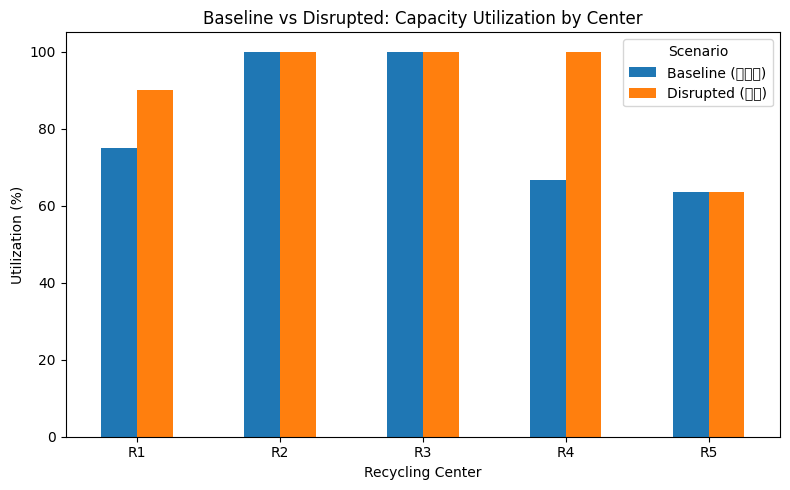

In [5]:
import matplotlib.pyplot as plt

# 使用之前生成的 df_table：
# 列包括：center, scenario, capacity, used, utilization_%

# 把表透视成：index = center, columns = scenario, values = utilization_%
util_pivot = df_table.pivot(index="center", columns="scenario", values="utilization_%")

print("利用率透视表：")
display(util_pivot)

# 画柱状图
ax = util_pivot.plot(
    kind="bar",
    figsize=(8, 5),
)

ax.set_title("Baseline vs Disrupted: Capacity Utilization by Center")
ax.set_xlabel("Recycling Center")
ax.set_ylabel("Utilization (%)")
plt.xticks(rotation=0)
plt.legend(title="Scenario")
plt.tight_layout()
plt.show()


In [7]:
from openai import OpenAI
import json

client = OpenAI()

SCENARIO_SYSTEM_PROMPT = """
你是锂电池回收供应链专家，专门把中文故障描述解析成结构化参数。

请严格输出一个 JSON 对象（不要有多余文字），格式为：
{
  "center_id": "R1",
  "capacity_factor": 0.5,
  "duration_days": 3,
  "summary_zh": "一句中文摘要"
}

字段含义：
- center_id: 受到影响的回收中心编号（R1/R2/R3/R4/R5 之一）
- capacity_factor: 故障期间的产能倍率（例如 0.4 表示剩 40% 产能）
- duration_days: 故障持续天数（整数）
- summary_zh: 用一句话总结这个场景
"""

def parse_scenario_with_llm(description_zh: str) -> dict:
    """调用 LLM，将中文场景描述解析为 JSON 参数。"""
    resp = client.responses.create(
        model="gpt-5-mini",   # 如有问题可改为 "gpt-4.1-mini"
        input=[
            {"role": "system", "content": SCENARIO_SYSTEM_PROMPT},
            {"role": "user", "content": description_zh},
        ],
    )
    text = resp.output_text
    print("LLM 原始输出：", text)
    parsed = json.loads(text)
    return parsed


In [8]:
# 多个中文场景描述，用来做 case study 对比
scenario_descriptions = {
    "R1_40pct": "未来 5 天，回收中心 R1 由于设备检修，产能下降到 40%。",
    "R3_40pct": "未来 5 天，回收中心 R3 因为严重故障，产能下降到 40%。",
    "R5_shutdown": "未来 5 天，回收中心 R5 完全停运，产能为 0。",
}


In [9]:
scenario_results = {}        # 保存每个场景的 OR 求解结果
scenario_parsed_params = {}  # 保存每个场景的 LLM 解析结果
scenario_capacity = {}       # 保存每个场景下的各中心产能

for name, desc in scenario_descriptions.items():
    print(f"\n===== 解析场景：{name} =====")
    print("描述：", desc)
    
    parsed = parse_scenario_with_llm(desc)
    scenario_parsed_params[name] = parsed
    
    affected_center = parsed["center_id"]
    factor = float(parsed["capacity_factor"])
    
    cap = base_capacity.copy()
    cap[affected_center] = base_capacity[affected_center] * factor
    scenario_capacity[name] = cap
    
    print("调整后的产能：", cap)
    
    result = solve_network(cap, title=f"scenario_{name}")
    scenario_results[name] = result

print("\n所有场景求解完成。")



===== 解析场景：R1_40pct =====
描述： 未来 5 天，回收中心 R1 由于设备检修，产能下降到 40%。
LLM 原始输出： {
  "center_id": "R1",
  "capacity_factor": 0.4,
  "duration_days": 5,
  "summary_zh": "未来5天回收中心R1因设备检修，产能降至40%。"
}
调整后的产能： {'R1': 48.0, 'R2': 100, 'R3': 80, 'R4': 90, 'R5': 110}

===== 解析场景：R3_40pct =====
描述： 未来 5 天，回收中心 R3 因为严重故障，产能下降到 40%。
LLM 原始输出： {
  "center_id": "R3",
  "capacity_factor": 0.4,
  "duration_days": 5,
  "summary_zh": "未来5天回收中心R3因严重故障，产能下降至40%。"
}
调整后的产能： {'R1': 120, 'R2': 100, 'R3': 32.0, 'R4': 90, 'R5': 110}

===== 解析场景：R5_shutdown =====
描述： 未来 5 天，回收中心 R5 完全停运，产能为 0。
LLM 原始输出： {
  "center_id": "R5",
  "capacity_factor": 0.0,
  "duration_days": 5,
  "summary_zh": "R5在未来5天完全停运，产能降为0。"
}
调整后的产能： {'R1': 120, 'R2': 100, 'R3': 80, 'R4': 90, 'R5': 0.0}

所有场景求解完成。


In [10]:
import pandas as pd

rows_scenario = []

for name, parsed in scenario_parsed_params.items():
    affected_center = parsed["center_id"]
    factor = float(parsed["capacity_factor"])
    duration = int(parsed["duration_days"])
    summary = parsed["summary_zh"]
    
    total_cost = scenario_results[name]["obj"]
    delta_cost = total_cost - baseline_result["obj"]
    delta_cost_pct = delta_cost / baseline_result["obj"] * 100
    
    rows_scenario.append({
        "scenario": name,
        "affected_center": affected_center,
        "capacity_factor": factor,
        "duration_days": duration,
        "summary_zh": summary,
        "total_cost": round(total_cost, 2),
        "delta_cost": round(delta_cost, 2),
        "delta_cost_%": round(delta_cost_pct, 2),
    })

df_scenario_summary = pd.DataFrame(rows_scenario)
df_scenario_summary = df_scenario_summary.sort_values(by="scenario").reset_index(drop=True)

print("===== 多场景成本对比（Case Study Summary） =====")
display(df_scenario_summary)


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [11]:
for name, res in scenario_results.items():
    print(name, "status:", res["status"], "obj:", res["obj"])


R1_40pct status: 2 obj: 968.0
R3_40pct status: 2 obj: 896.0
R5_shutdown status: 3 obj: None


In [12]:
import pandas as pd

rows_scenario = []

for name, parsed in scenario_parsed_params.items():
    affected_center = parsed["center_id"]
    factor = float(parsed["capacity_factor"])
    duration = int(parsed["duration_days"])
    summary = parsed["summary_zh"]
    
    res = scenario_results[name]
    status = res["status"]
    total_cost = res["obj"]  # 可能是 None

    # 如果模型不可行，直接标记为 "Infeasible"，不做减法
    if total_cost is None:
        rows_scenario.append({
            "scenario": name,
            "affected_center": affected_center,
            "capacity_factor": factor,
            "duration_days": duration,
            "summary_zh": summary,
            "status": "Infeasible",
            "total_cost": None,
            "delta_cost": None,
            "delta_cost_%": None,
        })
        continue  # 跳过后面的减法

    # 可行场景：正常计算成本增量
    baseline_cost = baseline_result["obj"]
    delta_cost = total_cost - baseline_cost
    delta_cost_pct = delta_cost / baseline_cost * 100

    rows_scenario.append({
        "scenario": name,
        "affected_center": affected_center,
        "capacity_factor": factor,
        "duration_days": duration,
        "summary_zh": summary,
        "status": "Optimal",
        "total_cost": round(total_cost, 2),
        "delta_cost": round(delta_cost, 2),
        "delta_cost_%": round(delta_cost_pct, 2),
    })

df_scenario_summary = pd.DataFrame(rows_scenario)
df_scenario_summary = df_scenario_summary.sort_values(by="scenario").reset_index(drop=True)

print("===== 多场景成本对比（Case Study Summary） =====")
display(df_scenario_summary)


===== 多场景成本对比（Case Study Summary） =====


,scenario,affected_center,capacity_factor,duration_days,summary_zh,status,total_cost,delta_cost,delta_cost_%
0,R1_40pct,R1,0.4,5,未来5天回收中心R1因设备检修，产能降至40%。,Optimal,968.0,138.0,16.63
1,R3_40pct,R3,0.4,5,未来5天回收中心R3因严重故障，产能下降至40%。,Optimal,896.0,66.0,7.95
2,R5_shutdown,R5,0.0,5,R5在未来5天完全停运，产能降为0。,Infeasible,NaN,NaN,NaN


In [14]:
import pandas as pd

rows_center = []

for scen_name, result in scenario_results.items():
    cap_dict = scenario_capacity[scen_name]
    
    # 可行性判断：如果 obj 是 None，说明模型不可行
    feasible = result["obj"] is not None
    
    for c in centers:
        cap = cap_dict[c]
        
        if feasible and c in result["used_by_center"]:
            used = result["used_by_center"][c]
            util = result["utilization"][c] * 100
        else:
            # 不可行场景，或者没有这个中心的数据：用 None 占位
            used = None
            util = None
        
        rows_center.append({
            "scenario": scen_name,
            "center": c,
            "capacity": cap,
            "used": None if used is None else round(used, 1),
            "utilization_%": None if util is None else round(util, 1),
        })

df_center_multi = pd.DataFrame(rows_center)
df_center_multi = df_center_multi.sort_values(
    by=["center", "scenario"]
).reset_index(drop=True)

print("===== 多场景下各回收中心利用率对比（长表形式） =====")
display(df_center_multi)


===== 多场景下各回收中心利用率对比（长表形式） =====


,scenario,center,capacity,used,utilization_%
0,R1_40pct,R1,48.0,48.0,100.0
1,R3_40pct,R1,120.0,108.0,90.0
2,R5_shutdown,R1,120.0,NaN,NaN
3,R1_40pct,R2,100.0,100.0,100.0
4,R3_40pct,R2,100.0,100.0,100.0
5,R5_shutdown,R2,100.0,NaN,NaN
6,R1_40pct,R3,80.0,80.0,100.0
7,R3_40pct,R3,32.0,32.0,100.0
8,R5_shutdown,R3,80.0,NaN,NaN
9,R1_40pct,R4,90.0,90.0,100.0


In [15]:
util_multi_pivot = df_center_multi.pivot_table(
    index="center",
    columns="scenario",
    values="utilization_%"
)

print("===== 各回收中心在不同故障场景下的利用率（%） =====")
display(util_multi_pivot)


===== 各回收中心在不同故障场景下的利用率（%） =====


scenario,R1_40pct,R3_40pct
center,,
R1,100.0,90.0
R2,100.0,100.0
R3,100.0,100.0
R4,100.0,100.0
R5,74.5,63.6
